# Анализ оттока клиентов из банка для выбор стратегии (удержание старых клиентов или привлечение новых клиентов).

## Описание данных.  
Признаки:
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — количество недвижимости у клиента
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата  

Целевой признак:
- Exited — факт ухода клиента

## План работ:
- 1 Подготовка данных.
- 2 Исследование задачи.
- 3 Борьба с дисбалансом.
- 4 Тестирование модели.
- 5 Общий вывод.

In [1]:
import pandas as pd

import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn.model_selection import train_test_split as tts

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression as lr
from sklearn.tree import DecisionTreeClassifier as dtc
from sklearn.ensemble import RandomForestClassifier as rfc

from sklearn.model_selection import GridSearchCV as gscv

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

import numpy as np

# 1. Подготовка данных

Откроем и рассмотрим файл с данными:

In [2]:
customers = pd.read_csv('datasets/Churn.csv')

In [3]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Видим пропуски в столбце Tenure.  Скорее всего это значит, что у клинта нет нгедвижимости.

In [4]:
customers.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Приведём столбцы к нижнему регистру:

In [5]:
customers.columns = customers.columns.str.lower()
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rownumber        10000 non-null  int64  
 1   customerid       10000 non-null  int64  
 2   surname          10000 non-null  object 
 3   creditscore      10000 non-null  int64  
 4   geography        10000 non-null  object 
 5   gender           10000 non-null  object 
 6   age              10000 non-null  int64  
 7   tenure           9091 non-null   float64
 8   balance          10000 non-null  float64
 9   numofproducts    10000 non-null  int64  
 10  hascrcard        10000 non-null  int64  
 11  isactivemember   10000 non-null  int64  
 12  estimatedsalary  10000 non-null  float64
 13  exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Помиотрим на гистограмму столбца tenure:

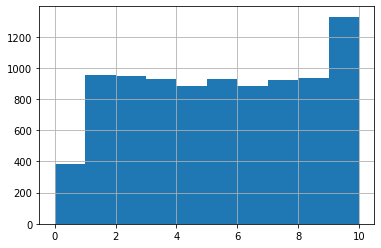

In [6]:
customers['tenure'].hist()

Заполним пропуски нулями:

In [7]:
customers.loc[:, 'tenure'].fillna(0.0, inplace=True)
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rownumber        10000 non-null  int64  
 1   customerid       10000 non-null  int64  
 2   surname          10000 non-null  object 
 3   creditscore      10000 non-null  int64  
 4   geography        10000 non-null  object 
 5   gender           10000 non-null  object 
 6   age              10000 non-null  int64  
 7   tenure           10000 non-null  float64
 8   balance          10000 non-null  float64
 9   numofproducts    10000 non-null  int64  
 10  hascrcard        10000 non-null  int64  
 11  isactivemember   10000 non-null  int64  
 12  estimatedsalary  10000 non-null  float64
 13  exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


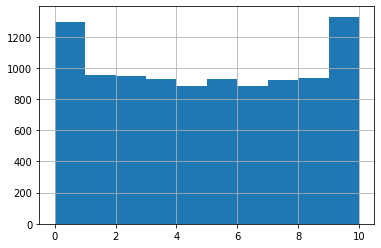

In [8]:
customers['tenure'].hist()

Вид гистограммы не потерял адекватность.  

Личные данные клиента для модели не будут иметь смысла, зато будут сбивать её. Удалим столбцы customerid(уникальный номер клиента), surname(фамилия) и rownumber(индекс строки в данных):

In [9]:
customers.drop(['customerid', 'surname', 'rownumber'], axis=1, inplace=True)
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   creditscore      10000 non-null  int64  
 1   geography        10000 non-null  object 
 2   gender           10000 non-null  object 
 3   age              10000 non-null  int64  
 4   tenure           10000 non-null  float64
 5   balance          10000 non-null  float64
 6   numofproducts    10000 non-null  int64  
 7   hascrcard        10000 non-null  int64  
 8   isactivemember   10000 non-null  int64  
 9   estimatedsalary  10000 non-null  float64
 10  exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


Посмотрим на графики:

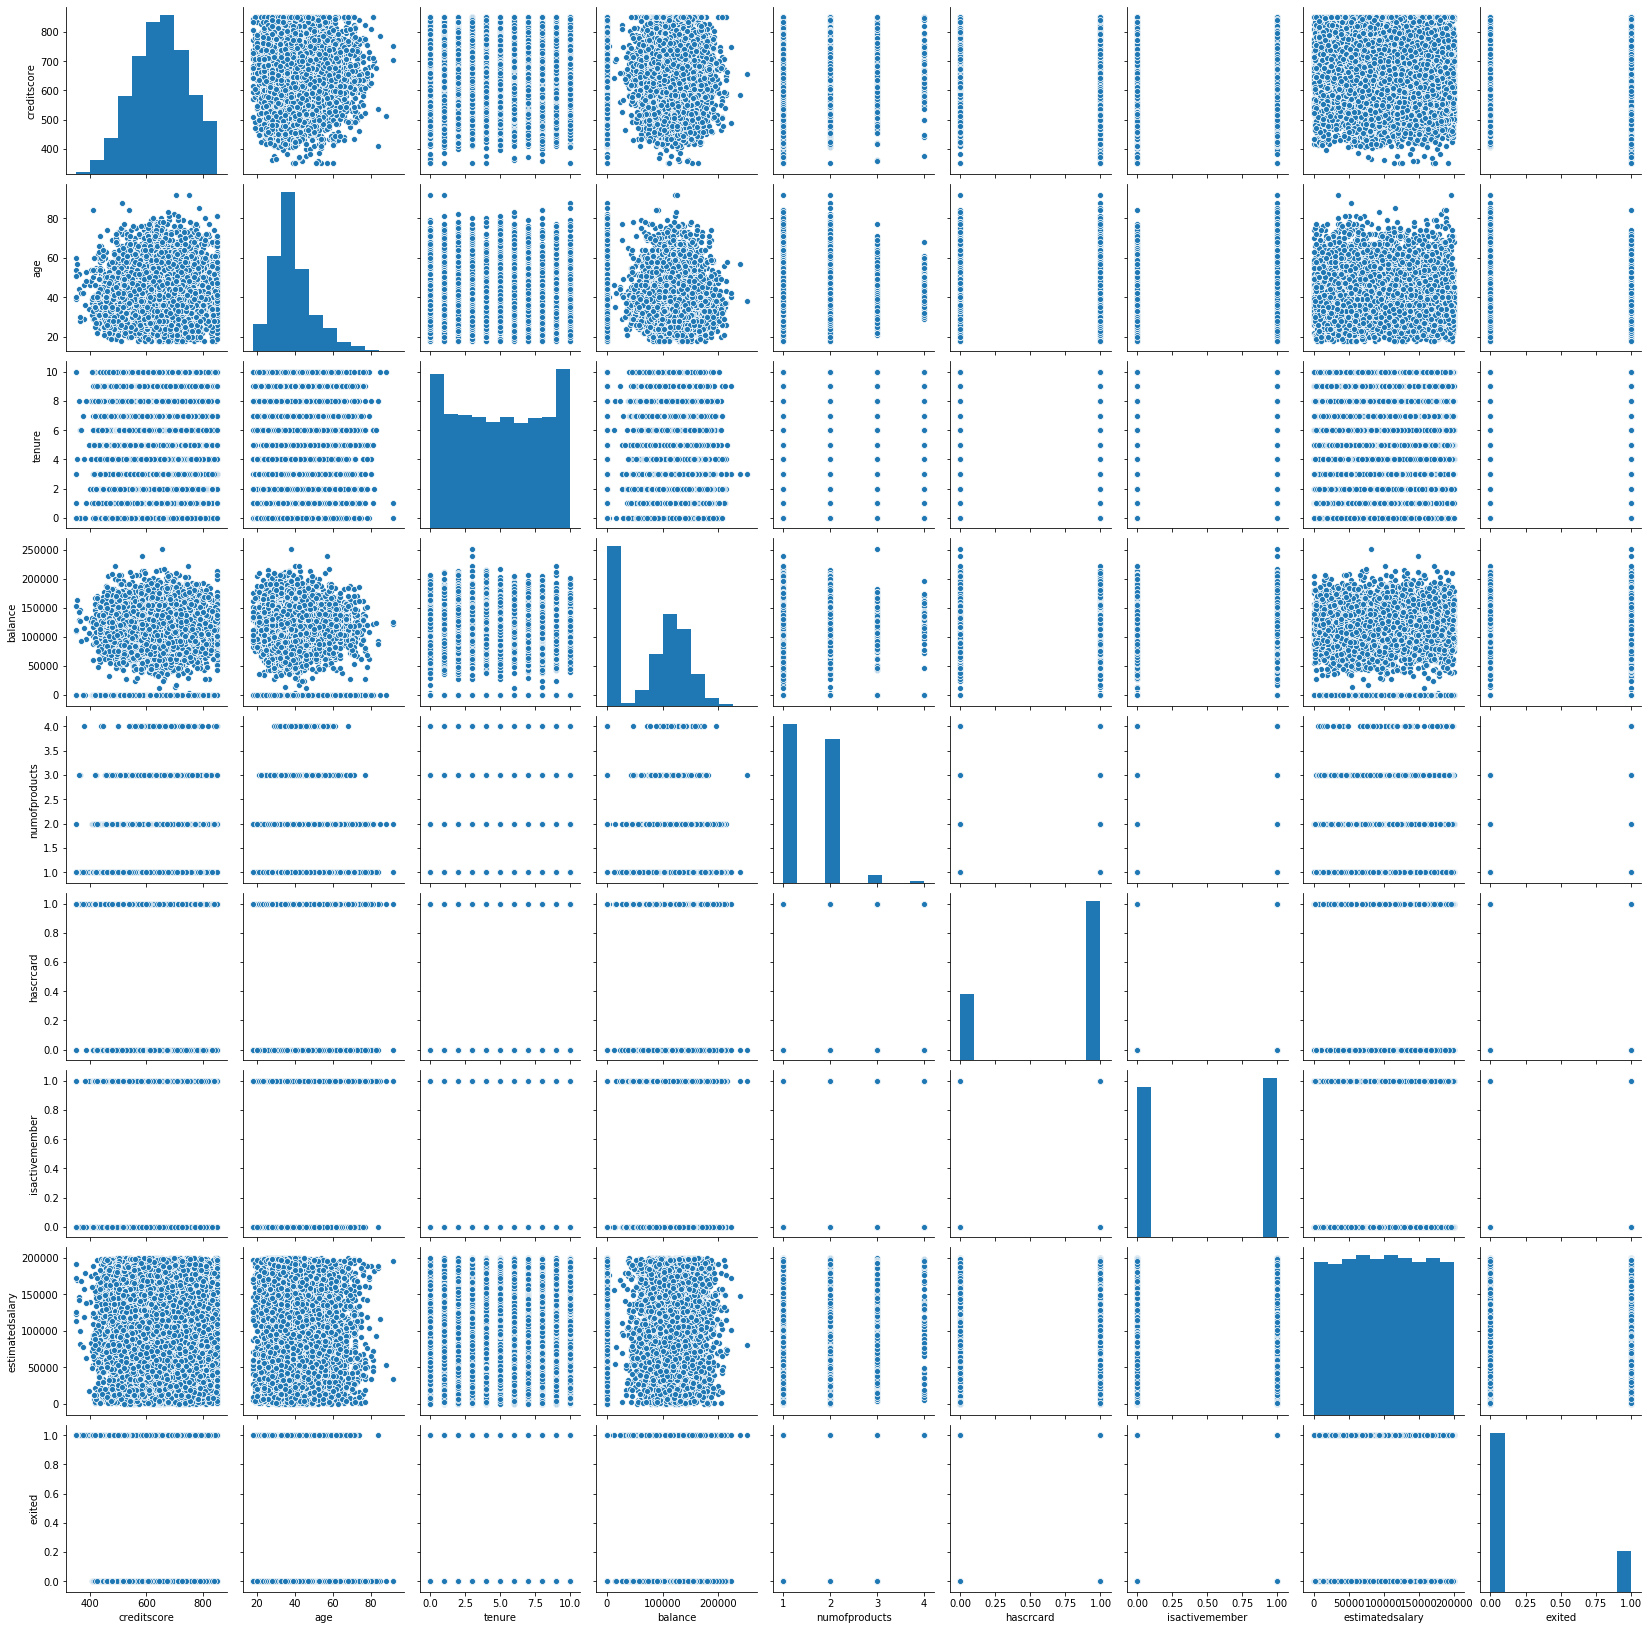

In [10]:
sns.pairplot(customers)

Посмотрим на корреляции всех признаков:

In [11]:
customers_corr = customers.drop(['geography', 'gender'], axis=1)
for i in customers_corr:
    for j in customers_corr:
        if j != i:
            corr = customers_corr[i].corr(customers_corr[j])
            if corr > 0.2:
                print(f'{i} коррелирует с {j} = {customers_corr[i].corr(customers_corr[j])}')

age коррелирует с exited = 0.28532303783506774
exited коррелирует с age = 0.2853230378350676


Корреляция у признаков слабая.  

Подготовим модель с использованием прямого кодирования(ohe для логистической регрессии) и порядкового кодирования(oe для деревьев). В нашей выборке есть 2 категориальных признака:

In [12]:
customers['geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [13]:
customers['gender'].unique()

array(['Female', 'Male'], dtype=object)

Признак gender можно сразу закодировать в основной выборке, т.к. там только 2 значения

In [14]:
customers.loc[:, 'gender'] = (customers.gender == 'Male').astype(int)
customers['gender'].unique()

array([0, 1])

Закодируем отдельную таблицу OneHotEncoder из столбца geography:

In [15]:
ohe = OneHotEncoder()
geography_ohe = ohe.fit_transform(customers[['geography']]).toarray()
geography_ohe = pd.DataFrame(geography_ohe, columns=ohe.categories_[0])
geography_ohe.head()

,France,Germany,Spain
0,1.0,0.0,0.0
1,0.0,0.0,1.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,0.0,0.0,1.0


Закодируем таблицу geography, используя OrdinalEncoder:

In [16]:
oe = OrdinalEncoder()
geography_oe = oe.fit_transform(customers[['geography']])
geography_oe = pd.DataFrame(geography_oe, columns=['geography'])
geography_oe.head()

,geography
0,0.0
1,2.0
2,0.0
3,0.0
4,2.0


Первоначальный столбец geography нам больше не нужен, т.к. это тип данных object, а его модели не воспринимают. Заменим его на закодированный столбец из OrdinalEncoder, и при необходимости, будем его исключать из обучения моделей:

In [17]:
customers.loc[:, 'geography'] = geography_oe.loc[:, 'geography']
customers.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,0.0,0,42,2.0,0.00,1,1,1,101348.88,1
1,608,2.0,0,41,1.0,83807.86,1,0,1,112542.58,0
2,502,0.0,0,42,8.0,159660.80,3,1,0,113931.57,1
3,699,0.0,0,39,1.0,0.00,2,0,0,93826.63,0
4,850,2.0,0,43,2.0,125510.82,1,1,1,79084.10,0


Присоеденим к основной таблице закодированную таблицу с помощью OneHotEncoder:

In [18]:
customers = customers.join(geography_ohe)
customers.columns = customers.columns.str.lower()
customers.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,france,germany,spain
0,619,0.0,0,42,2.0,0.00,1,1,1,101348.88,1,1.0,0.0,0.0
1,608,2.0,0,41,1.0,83807.86,1,0,1,112542.58,0,0.0,0.0,1.0
2,502,0.0,0,42,8.0,159660.80,3,1,0,113931.57,1,1.0,0.0,0.0
3,699,0.0,0,39,1.0,0.00,2,0,0,93826.63,0,1.0,0.0,0.0
4,850,2.0,0,43,2.0,125510.82,1,1,1,79084.10,0,0.0,0.0,1.0


In [19]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   creditscore      10000 non-null  int64  
 1   geography        10000 non-null  float64
 2   gender           10000 non-null  int32  
 3   age              10000 non-null  int64  
 4   tenure           10000 non-null  float64
 5   balance          10000 non-null  float64
 6   numofproducts    10000 non-null  int64  
 7   hascrcard        10000 non-null  int64  
 8   isactivemember   10000 non-null  int64  
 9   estimatedsalary  10000 non-null  float64
 10  exited           10000 non-null  int64  
 11  france           10000 non-null  float64
 12  germany          10000 non-null  float64
 13  spain            10000 non-null  float64
dtypes: float64(7), int32(1), int64(6)
memory usage: 1.0 MB


Посмотрим на баланс целевого признака:

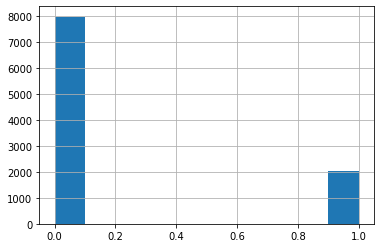

In [20]:
customers.exited.hist()

С балансом наблюдаются проблемы. Данные подготовлены для исследования.

# 2. Исследование задачи

Разделим выборку на trein, valid и test:

In [21]:
features = customers.drop(['exited'], axis=1)
target = customers['exited']
features_train, features_valid_test, target_train, target_valid_test = tts(features, target,
                                                                           test_size=0.2, random_state=12345,
                                                                           stratify=target)
features_valid, features_test, target_valid, target_test = tts(features_valid_test, target_valid_test,
                                                               test_size=0.5, random_state=12345,
                                                               stratify=target_valid_test)

Подготовим признаки для Логистической регресии:

In [22]:
features_train_lr = features_train.drop(['geography'], axis=1)
features_valid_lr = features_valid.drop(['geography'], axis=1)
features_test_lr = features_test.drop(['geography'], axis=1)

Подготовим признаки для Деревянных моделей:

In [23]:
features_train_tree = features_train.drop(['france', 'germany', 'spain'], axis=1)
features_valid_tree = features_valid.drop(['france', 'germany', 'spain'], axis=1)
features_test_tree = features_test.drop(['france', 'germany', 'spain'], axis=1)

In [24]:
features_train_lr.head()

,creditscore,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,france,germany,spain
3376,644,0,40,4.0,77270.08,2,1,1,115800.10,0.0,1.0,0.0
1315,607,0,27,5.0,100912.19,1,0,0,7631.27,0.0,0.0,1.0
2552,599,0,46,7.0,81742.84,2,1,0,83282.21,0.0,0.0,1.0
511,632,0,38,6.0,86569.76,2,1,0,98090.91,0.0,1.0,0.0
1888,429,1,60,7.0,0.00,2,1,1,163691.48,1.0,0.0,0.0


Масштабируем количественные признаки для Логистической регрессии:

In [25]:
numeric = ['creditscore', 'age', 'balance', 'estimatedsalary']

In [26]:
scaler = StandardScaler()
scaler.fit(features_train_lr[numeric])
features_train_lr[numeric] = scaler.transform(features_train_lr[numeric])
features_valid_lr[numeric] = scaler.transform(features_valid_lr[numeric])
features_test_lr[numeric] = scaler.transform(features_test_lr[numeric])

Обучим модели. Сначала Логистическую регрессию, потом Дерево решений и Случапйный лес:  
- Логистическая регрессия:

In [27]:
model_lr = lr(random_state=12345, solver='lbfgs')
model_lr.fit(features_train_lr, target_train)
predicted_valid_lr = model_lr.predict(features_valid_lr)

In [28]:
print(classification_report(target_valid, predicted_valid_lr))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89       796
           1       0.61      0.20      0.30       204

    accuracy                           0.81      1000
   macro avg       0.72      0.58      0.59      1000
weighted avg       0.78      0.81      0.77      1000



In [29]:
print(classification_report(target_valid, predicted_valid_lr))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89       796
           1       0.61      0.20      0.30       204

    accuracy                           0.81      1000
   macro avg       0.72      0.58      0.59      1000
weighted avg       0.78      0.81      0.77      1000



In [30]:
print(f1_score(target_valid, predicted_valid_lr))

0.2962962962962963


Посмотрим на меру AUC-ROC:

In [31]:
probabilities_valid_lr = model_lr.predict_proba(features_valid_lr)
probabilities_one_valid_lr = probabilities_valid_lr[:, 1]

auc_roc_lr = roc_auc_score(target_valid, probabilities_one_valid_lr)
print(auc_roc_lr)

0.7819551187309096


AUC-ROC далёк от единицы.

- Дерево решений:  

Подберём наилучшие параметры с помощью GridSearchCV:

Разобъём выборку на тренировочную и тестовую:

In [32]:
features_train_gs, features_test_sd, target_train_gs, target_test_gs = tts(features, target,
                                                                           test_size=0.1, random_state=12345,
                                                                           stratify=target)

In [33]:
param_grid_dtc = {'max_depth': [depth for depth in range(4, 16)]}
gs_dtc = gscv(dtc(), param_grid=param_grid_dtc, cv=5)

In [34]:
gs_dtc.fit(features_train_gs.drop(['france', 'germany', 'spain'], axis=1), target_train_gs)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
 

In [35]:
param_grid_dtc = {'max_depth': [depth for depth in range(4, 16)]}
gs_dtc = gscv(dtc(), param_grid=param_grid_dtc, cv=5)

features_cv = pd.concat([features_train_tree, features_valid_tree])
target_cv = pd.concat([target_train, target_valid])

gs_dtc.fit(features_cv, target_cv)
gs_dtc.best_params_

{'max_depth': 5}

In [36]:
gs_dtc.best_params_
#{'max_depth': 5}

{'max_depth': 5}

Обучим модель:

In [37]:
model_dtc = dtc(max_depth=5, random_state=12345)
model_dtc.fit(features_train_tree, target_train)
predicted_valid_dtc = model_dtc.predict(features_valid_tree)

In [38]:
print(classification_report(target_valid, predicted_valid_dtc))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       796
           1       0.74      0.45      0.56       204

    accuracy                           0.85      1000
   macro avg       0.80      0.70      0.74      1000
weighted avg       0.84      0.85      0.84      1000



In [39]:
print(f1_score(target_valid, predicted_valid_dtc))

0.5592705167173253


In [40]:
probabilities_valid_dtc = model_dtc.predict_proba(features_valid_tree)
probabilities_one_valid_dtc = probabilities_valid_dtc[:, 1]

auc_roc_dtc = roc_auc_score(target_valid, probabilities_one_valid_dtc)
print(auc_roc_dtc)

0.8422289141787368


AUC-ROC далёк от единицы.

- Случайный лес:

In [41]:
param_grid_rfc = {'max_depth': [depth for depth in range(5, 16)], 'n_estimators': [estim for estim in range(90, 150, 10)]}
gs_rfc = gscv(rfc(), param_grid=param_grid_rfc, cv=5)

In [42]:
gs_rfc.fit(features_train_gs.drop(['france', 'germany', 'spain'], axis=1), target_train_gs)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [43]:
gs_rfc.best_params_
#{'max_depth': 12, 'n_estimators': 140}

{'max_depth': 12, 'n_estimators': 140}

In [44]:
model_rfc = rfc(n_estimators=140, max_depth=12, random_state=12345)
model_rfc.fit(features_train_tree, target_train)
predicted_valid_rfc = model_rfc.predict(features_valid_tree)

In [45]:
print(classification_report(target_valid, predicted_valid_rfc))

              precision    recall  f1-score   support

           0       0.87      0.97      0.91       796
           1       0.77      0.41      0.54       204

    accuracy                           0.85      1000
   macro avg       0.82      0.69      0.73      1000
weighted avg       0.85      0.85      0.84      1000



In [46]:
print(f1_score(target_valid, predicted_valid_rfc))

0.536741214057508


In [47]:
probabilities_valid_rfc = model_rfc.predict_proba(features_valid_tree)
probabilities_one_valid_rfc = probabilities_valid_rfc[:, 1]

auc_roc_rfc = roc_auc_score(target_valid, probabilities_one_valid_rfc)
print(auc_roc_rfc)

0.8685153709725096


AUC-ROC ближе, чем у двух предыдущих моделей, но не идиален.

F1-мера менее 0.56 у всех моделей. AUC-ROC выглядит лучше, но тоже не на высоте. Видимо дисбаланс слишком сильно влияет на обучение. Будем с ним бороться.

# 3. Борьба с дисбалансом

Разделим выборку на 0 и 1:

- Единицы:

In [48]:
features_train_up = features_train[target_train == 1]
features_train_up.shape[0]

1630

In [49]:
target_train_up = target_train[target_train == 1]
target_train_up.shape

(1630,)

- Нули:

In [50]:
features_train_down = features_train[target_train == 0]
features_train_down.shape[0]

6370

In [51]:
target_train_down = target_train[target_train == 0]
target_train_down.shape

(6370,)

Посмотрим на разницу целевого признака 0 и 1:

In [52]:
difference = target_train_down.shape[0] - target_train_up.shape[0]
difference

4740

### Апсемплинг:  

Подготовим данные для апсэмплинга, используя метод sample. Колличество единиц поднимем на разницу между 0 и 1(переменная difference):

In [53]:
features_train_upsampling = features_train_up.sample(difference, replace=True)
features_train_upsampling.shape

(4740, 13)

Объеденим увеличенные данные единиц с данными нулей:

In [54]:
features_train_upsampling = pd.concat([features_train_upsampling, features_train_down])
features_train_upsampling.shape

(11110, 13)

In [55]:
target_train_upsampling = pd.Series(np.repeat(1, difference))
target_train_upsampling = pd.concat([target_train_upsampling, target_train_down])
target_train_upsampling.shape

(11110,)

####  Даунсэмплинг:  

Подготовим данные для даунсэмплинга, используя метод sample. Возьмем из данных количество нулей, равное колличеству единиц с помощью sample:

In [56]:
features_train_downsampling = features_train_down.sample(features_train_up.shape[0])
features_train_downsampling.shape

(1630, 13)

In [57]:
target_train_downsampling = pd.Series(np.repeat(0, target_train_up.shape[0]))
target_train_downsampling.shape

(1630,)

Объеденим уменьшенные данные нулей с данными единиц:

In [58]:
features_train_downsampling = pd.concat([features_train_downsampling, features_train_up])
features_train_downsampling.shape

(3260, 13)

In [59]:
target_train_downsampling = pd.concat([target_train_downsampling, target_train_up])
target_train_downsampling.shape

(3260,)

#### Смешанный вариант:

Возьмём утроенное количество единиц, и равное этому колличеству число нулей:

In [60]:
up_down = target_train_up.shape[0] * 3
up_down

4890

In [61]:
up = features_train_up.sample(up_down, replace=True)
down = features_train_down.sample(up_down)
features_train_up_down = pd.concat([up, down])
features_train_up_down.shape

(9780, 13)

In [62]:
up_t = pd.Series(np.repeat(1, up_down))
down_t = pd.Series(np.repeat(0, up_down))
target_train_up_down = pd.concat([up_t, down_t])
target_train_up_down.shape

(9780,)

Пообучаем Случайный лес и проверим показатели:  
- Сначала апсемплинг:

In [63]:
model_rfc_up = rfc(n_estimators=120, max_depth=10, random_state=12345)
model_rfc_up.fit(features_train_upsampling.drop(['france', 'germany', 'spain'], axis=1), target_train_upsampling)
predicted_valid_rfc_up = model_rfc_up.predict(features_valid.drop(['france', 'germany', 'spain'], axis=1))

In [64]:
print(classification_report(target_valid, predicted_valid_rfc_up))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       796
           1       0.66      0.65      0.65       204

    accuracy                           0.86      1000
   macro avg       0.78      0.78      0.78      1000
weighted avg       0.86      0.86      0.86      1000



In [65]:
best_score = {}
uped = f1_score(target_valid, predicted_valid_rfc_up)
best_score['upsampling'] = uped
print(uped)

0.6518518518518519


In [66]:
probabilities_valid_rfc_up = model_rfc_up.predict_proba(features_valid.drop(['france', 'germany', 'spain'], axis=1))
probabilities_one_valid_rfc = probabilities_valid_rfc_up[:, 1]

auc_roc_rfc_up = roc_auc_score(target_valid, probabilities_one_valid_rfc)
print(auc_roc_rfc_up)

0.8734481229677801


- Теперь даунсемплинг:

In [67]:
model_rfc_down = rfc(n_estimators=120, max_depth=10, random_state=12345)
model_rfc_down.fit(features_train_downsampling.drop(['france', 'germany', 'spain'], axis=1), target_train_downsampling)
predicted_valid_rfc_down = model_rfc_down.predict(features_valid.drop(['france', 'germany', 'spain'], axis=1))

In [68]:
print(classification_report(target_valid, predicted_valid_rfc_down))

              precision    recall  f1-score   support

           0       0.94      0.80      0.86       796
           1       0.50      0.78      0.61       204

    accuracy                           0.80      1000
   macro avg       0.72      0.79      0.74      1000
weighted avg       0.85      0.80      0.81      1000



In [69]:
f1_score(target_valid, predicted_valid_rfc_down)

0.6130268199233716

In [70]:
downed = f1_score(target_valid, predicted_valid_rfc_down)
best_score['downsampling'] = downed
print(downed)

0.6130268199233716


In [71]:
probabilities_valid_rfc_down = model_rfc_down.predict_proba(features_valid.drop(['france', 'germany', 'spain'], axis=1))
probabilities_one_valid_rfc_down = probabilities_valid_rfc_down[:, 1]

auc_roc_rfc_down = roc_auc_score(target_valid, probabilities_one_valid_rfc_down)
print(auc_roc_rfc_down)

0.8642046014385653


- Оценим модель, обученную на смешанных данных:

In [72]:
model_rfc_up_down = rfc(n_estimators=120, max_depth=10, random_state=12345)
model_rfc_up_down.fit(features_train_up_down.drop(['france', 'germany', 'spain'], axis=1), target_train_up_down)
predicted_valid_rfc_up_down = model_rfc_up_down.predict(features_valid.drop(['france', 'germany', 'spain'], axis=1))

Посмотрим на AUC-ROC:

In [73]:
probabilities_valid_rfc_up_down = model_rfc_up_down.predict_proba(features_valid.drop(['france', 'germany', 'spain'], axis=1))
probabilities_one_valid_rfc_up_down = probabilities_valid_rfc_up_down[:, 1]

auc_roc_rfc_up_down = roc_auc_score(target_valid, probabilities_one_valid_rfc_up_down)
print(auc_roc_rfc_up_down)

0.867197507143561


In [74]:
print(classification_report(target_valid, predicted_valid_rfc_up_down))

              precision    recall  f1-score   support

           0       0.92      0.85      0.89       796
           1       0.56      0.72      0.63       204

    accuracy                           0.83      1000
   macro avg       0.74      0.78      0.76      1000
weighted avg       0.85      0.83      0.83      1000



In [75]:
uped_downed = f1_score(target_valid, predicted_valid_rfc_up_down)
best_score['up + downsampling'] = uped_downed
print(uped_downed)

0.6266094420600858


In [76]:
print(best_score)

{'upsampling': 0.6518518518518519, 'downsampling': 0.6130268199233716, 'up + downsampling': 0.6266094420600858}


In [77]:
print(f'Лучше всего модель обучилась на выборке {max(best_score, key=best_score.get)} с показателем f1 меры {best_score.get(max(best_score, key=best_score.get))}')

Лучше всего модель обучилась на выборке upsampling с показателем f1 меры 0.6518518518518519


# 4. Тестирование модели

Протестируем модель с усреднёнными данными:

In [78]:
predicted_test_rfc_up_down = model_rfc_up_down.predict(features_test.drop(['france', 'germany', 'spain'], axis=1))

In [79]:
print(classification_report(target_test, predicted_test_rfc_up_down))

              precision    recall  f1-score   support

           0       0.92      0.85      0.88       797
           1       0.55      0.69      0.61       203

    accuracy                           0.82      1000
   macro avg       0.73      0.77      0.75      1000
weighted avg       0.84      0.82      0.83      1000



In [80]:
print(f1_score(target_test, predicted_test_rfc_up_down))

0.6100217864923748


In [81]:
probabilities_valid_rfc_up_down_test = model_rfc_up_down.predict_proba(features_test.drop(['france', 'germany', 'spain'], axis=1))
probabilities_one_valid_rfc_up_down_test = probabilities_valid_rfc_up_down_test[:, 1]

auc_roc_rfc_up_down_test = roc_auc_score(target_test, probabilities_one_valid_rfc_up_down_test)
print(auc_roc_rfc_up_down_test)

0.861333448708519


Протестируем модель с апсемплингом:

In [82]:
predicted_test_rfc_up = model_rfc_up.predict(features_test.drop(['france', 'germany', 'spain'], axis=1))
print(f1_score(target_test, predicted_test_rfc_up))

0.6210268948655256


In [83]:
probabilities_valid_rfc_up_test = model_rfc_up.predict_proba(features_test.drop(['france', 'germany', 'spain'], axis=1))
probabilities_one_valid_rfc_up_test = probabilities_valid_rfc_up_test[:, 1]

auc_roc_rfc_up_test = roc_auc_score(target_test, probabilities_one_valid_rfc_up_test)
print(auc_roc_rfc_up_test)

0.8567596467046993


Значение f1 меры немного снизилось. AUC-ROC держится примерно на томже уровне.

# 5. Общий вывод

Были проанализированы и подготовлены данные «Бета-Банка». Обучены модели без учёта дисбаланса классов. Произведены 3 вида балансировки классов и заново обучены модели. Показатели f1 меры улучшились значительно с 0.54 до 0.64 - слабовато. AUC-ROC сильно не менялся, но ответы модели далеки от случайных на разных вариантах этой самой балансировки. Проведено финальное тестирование, на котором показатель f1 снизился до 0.63.